In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull

import itertools
import random

from utils import *
from helper import *
from collections import Counter

plt.style.use('seaborn-darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

np.random.seed(260647775)

In [4]:
def condition(coord):
    x, y = coord
    
    return (x-25)**2 + (y-25)**2 < 225 # radius 15

grid      = [[(x, y) for y in range(50)] for x in range(50)]
grayscale = [[2 if condition(tup) else 0.5 for tup in row] for row in grid]

In [5]:
noise = np.random.normal(0, 0.7, size=(50, 50))

In [6]:
noisy_image = grayscale - noise
np.putmask(noisy_image, noisy_image < 0, 0)
np.putmask(noisy_image, noisy_image > 2, 2)

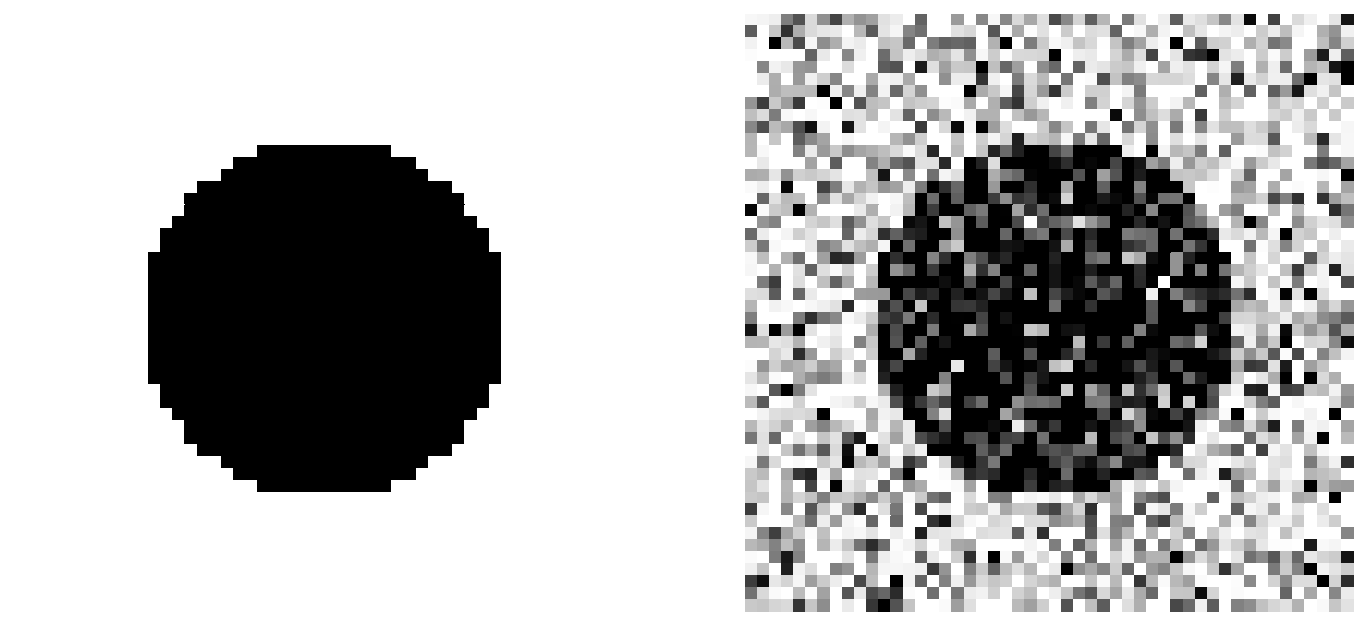

In [7]:
fig, axes = plt.subplots(figsize=(12, 5.5), nrows=1, ncols=2)

axes[0] = sns.heatmap(grayscale,
                        cmap='Greys',
                        cbar=False,
                        xticklabels='',
                        yticklabels='',
                        ax=axes[0])
plt.axis('off')
axes[1] = sns.heatmap(noisy_image,
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[1])

#### Initialization of random points

In [8]:
num_points = 12
points = random_tessellation_points(num_points)

In [9]:
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)
updated_vertices = {i: restricted_vertices(vertices[regions[i]], points[i]) for i in range(len(points))}

In [10]:
# manually add corners somewhere
# order no longer matters
for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:
    
    region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in points])
    temp_vertices = updated_vertices[region_where_corner_belongs].copy()
    
    updated_vertices[region_where_corner_belongs] = np.array(list(temp_vertices) + [corner] )

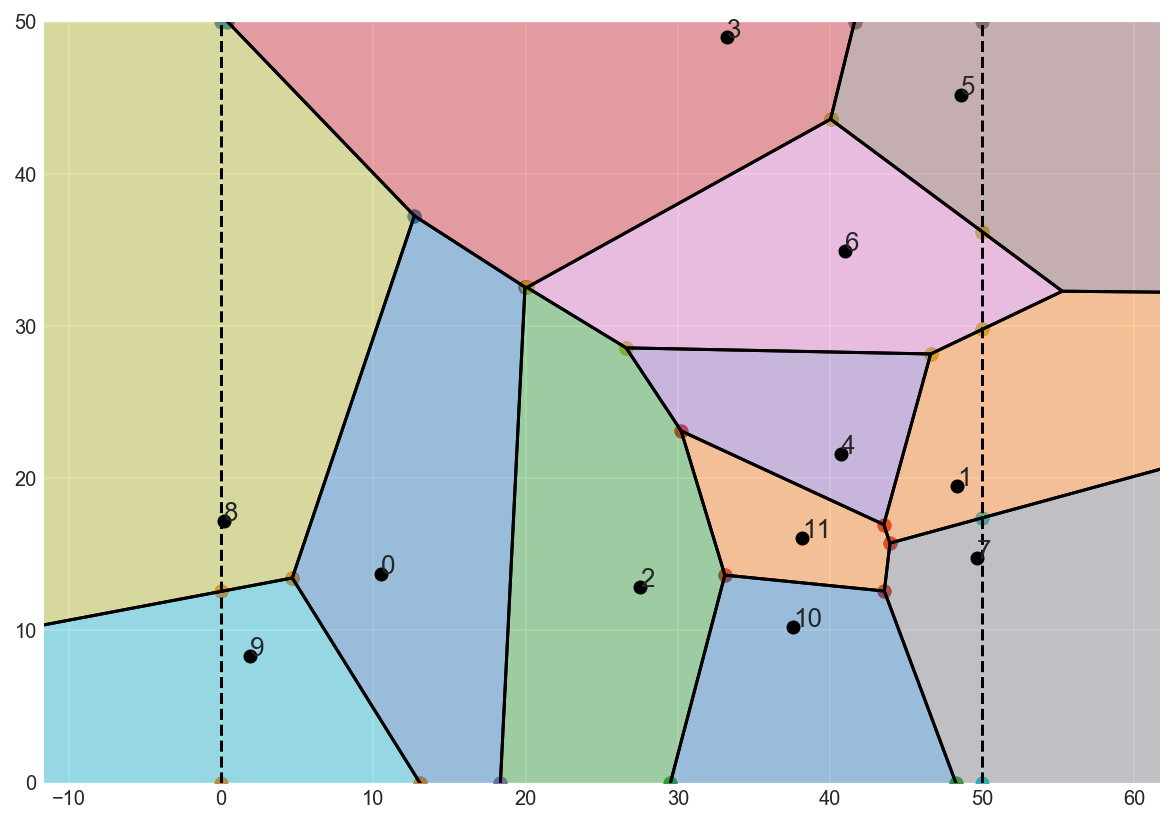

In [11]:
fig = plt.figure(figsize=(10, 7))
plot(points)

for i, region in enumerate(regions):
    try:
        a, b = zip(*updated_vertices[i])
        plt.scatter(a, b)
    except Exception as e:
        pass

In [12]:
total_area = 0
for i in range(num_points):
    print('{}th region: {} vertices\t area = {}'.format(i, len(updated_vertices[i]), PolyArea(updated_vertices[i])))
    total_area += PolyArea(updated_vertices[i])
print('Total area: ', np.around(total_area, 3))

0th region: 5 vertices	 area = 374.2795407809911
1th region: 5 vertices	 area = 60.52151538171802
2th region: 7 vertices	 area = 351.30703084999595
3th region: 6 vertices	 area = 433.7073282853803
4th region: 4 vertices	 area = 137.97189754300462
5th region: 4 vertices	 area = 95.63885898239641
6th region: 6 vertices	 area = 291.94590190089684
7th region: 5 vertices	 area = 76.05019458932247
8th region: 5 vertices	 area = 292.3851393430408
9th region: 4 vertices	 area = 117.0667730652032
10th region: 4 vertices	 area = 191.2350656268727
11th region: 5 vertices	 area = 77.89075365117719
Total area:  2500.0


#### Constants


In [22]:
lam = 15 # lambda
alpha = 1 # alpha
beta  = 1 # beta
sigma = 0.7
k = 15

coordinates = np.array([[(i + 0.5, j + 0.5) for i in range(50)] for j in range(50)])
coordinates = coordinates.reshape(-1, 2)

#### Sampler

In [29]:
NUM_ITER = 20000

In [30]:
x_sample = []
k_sample = []

count = 0
death = 0
birth = 0
skip  = 0

while len(x_sample) < NUM_ITER:

    if count % 100 == 0:
        print('Done sampling ', count)
    
    points  = random_tessellation_points(k)
    old_Voronoi = UpdatedVoronoi(points)
    
    counter = Counter(old_Voronoi.x_heights)
    ni = np.array([counter[r] for r in range(k)])
    sum_yi = np.array([sum(noisy_image.reshape(-1)[np.argwhere(np.array(old_Voronoi.x_heights) == r).reshape(-1)]) for r in range(k)])
    
    heights = np.random.normal(loc=(sum_yi + 0.7**2)/ni, scale=np.sqrt(0.7**2/ni))
    
#     if any(heights <= 0):
#         invalid_heights = np.argwhere(heights <= 0).reshape(-1)
#         heights[invalid_heights] = 0.1 # sketchy solution

    new_point   = np.random.uniform(low=0, high=50, size=[1, 2])
    temp_points = np.concatenate((points, new_point.reshape(1, 2)))
    new_Voronoi = UpdatedVoronoi(temp_points)

#    J = get_neighbors(new_Voronoi, k) # k is last index of new voronoi, J as defined in Green (1995)
    diff_areas = (old_Voronoi.areas - new_Voronoi.areas[:-1])
    J = np.argwhere(diff_areas > 1e-7).reshape(-1).astype(np.int32)
    
#    assert all(np.argwhere(diff_areas > 1e-7).reshape(-1).astype(np.int32) == np.sort(J))

    S, T = diff_areas[J], new_Voronoi.areas[J] # change in areas, new areas
    
    try:
        assert np.abs(sum(S) - new_Voronoi.areas[-1]) < 1e-7 # change in areas same as area of new region
    except:
        print('Error in birth process')
        print('S: ', S)
        print('Expected area: ', new_Voronoi.areas[-1])
        print('Current number of tiles (k): ', k)
        print('Neighbors of i*: ', J)

    v = inverse_v(np.random.uniform(0, 1)) # ~ f(v)
    h_tilde = np.exp(1/sum(S)*(S@np.log(heights[J]))) # no worries about height = 0
    h_star  = h_tilde*v
    heights = np.array(list(heights) + [h_star])

    new_heights  = heights[J]**(1+S/T)*(np.tile(h_star, len(J))**(-S/T))
    loglikeratio = log_likelihood_ratio(noisy_image.reshape(-1,), 
                                        heights[new_Voronoi.x_heights], 
                                        heights[old_Voronoi.x_heights])
    # check if R < or > than 0
    logR = loglikeratio + \
           np.log(lam) - \
           h_star - \
           sum(new_heights - heights[J]) - \
           np.log(poisson_ratio_pdf(k)*h_tilde/f(v)) - \
           np.log(sum((S+T)*new_heights/(T*heights[J])))



    if logR < 0:
        if np.random.binomial(n=1, p=np.exp(logR)):
            birth += 1
            
            heights[J] = new_heights
            assert len(heights) == max(new_Voronoi.x_heights) + 1 # birth

            k = k+1
            x_sample.append(heights[new_Voronoi.x_heights])
            k_sample.append(k)
            
        else:
            x_sample.append(heights[old_Voronoi.x_heights])
            k_sample.append(k)

    else:
        if np.random.binomial(n=1, p=np.exp(-logR)):
            if k == 3:
                skip += 1
                continue
            death += 1
            
            heights = heights[:-1] # removing h_star
            

            delete_tile = random.choice(range(len(points)))
            temp_points = np.delete(points, delete_tile, axis=0)

            new_Voronoi = UpdatedVoronoi(temp_points)

            #J = get_neighbors(old_Voronoi, delete_tile) # tile no longer exists in new_Voronoi
            
            _temp_areas = np.insert(new_Voronoi.areas, delete_tile, 0)
            diff_areas  = (_temp_areas - old_Voronoi.areas)

            J = np.argwhere(diff_areas > 1e-7).reshape(-1).astype(np.int32)

            S, T = diff_areas[J], old_Voronoi.areas[J] # change in areas, new areas

            try:
                assert np.abs(sum(S) - old_Voronoi.areas[delete_tile]) < 1e-7 # change in areas same as area of new region
            except Exception as e:
                print('Error in death process')
                print('S: ', S)
                print('Expected area: ', new_Voronoi.areas[-1])
                print('Current number of tiles (k): ', k)
                print('Neighbors of delete_tile: ', J)

            v = inverse_v(np.random.uniform(0, 1))
            h_tilde = np.exp(1/sum(S)*(S@np.log(heights[J]))) # no worries about height = 0
            h_star  = h_tilde*v
            #height
            s = np.insert(heights, delete_tile, 0)

            new_heights  = heights[J]**(T/(S+T))*(h_star**(S/(S+T)))
            heights[J] = new_heights
            heights = np.delete(heights, delete_tile)

            assert len(heights) == max(new_Voronoi.x_heights) + 1 # death
            
            k = k-1
            x_sample.append(heights[new_Voronoi.x_heights])
            k_sample.append(k)
        
        else:
            x_sample.append(heights[old_Voronoi.x_heights])
            k_sample.append(k)

    count += 1

np.save('x_samples.npy', np.array(x_sample))
np.save('k_samples.npy', np.array(k_sample))

Done sampling  0
Done sampling  100
Done sampling  200
Done sampling  300
Done sampling  400
Done sampling  500
Done sampling  600
Done sampling  700
Done sampling  800
Done sampling  900
Done sampling  1000
Done sampling  1100
Done sampling  1200
Done sampling  1300


AssertionError: 

In [33]:
sum(S), new_Voronoi.areas[-1]

(591.7946680496223, 737.693888494071)

Below for debugging purposes

In [ ]:
fig = plt.figure(figsize=(10, 7))
plot(temp_points)

In [ ]:
fig = plt.figure(figsize=(10, 7))
plot(points)

In [ ]:
fig, axes = plt.subplots(figsize=(18, 5.5), nrows=1, ncols=3)
axes[0] = sns.heatmap(grayscale,
                        cmap='Greys',
                        cbar=False,
                        xticklabels='',
                        yticklabels='',
                        ax=axes[0])
plt.axis('off')
axes[1] = sns.heatmap(noisy_image,
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[1])

axes[2] = sns.heatmap(np.mean(x_sample, axis=0).reshape(50, 50), 
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[2])

axes[0].set_title('Image with no noise', fontsize=18)
axes[1].set_title('Image with added noise', fontsize=18)
axes[2].set_title('Deblurred image', fontsize=18)

In [ ]:
plot(rr)

In [ ]:
plot(rr, limits=False)

In [ ]:
UpdatedVoronoi(np.concatenate((rr, [[100, 100]])))

In [ ]:
points = random_tessellation_points(10)
vor = Voronoi(points)

In [ ]:
plot(points)

In [ ]:
regions, vertices = voronoi_finite_polygons_2d(Voronoi(points))
updated_vertices = {i: restricted_vertices(vertices[regions[i]], points[i]) for i in range(len(points))}
regions

In [ ]:
# manually add corners somewhere
# order no longer matters
for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:
    
    region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in points])
    temp_vertices = updated_vertices[region_where_corner_belongs].copy()
    
    updated_vertices[region_where_corner_belongs] = np.array(list(temp_vertices) + [corner] )

In [ ]:
total_area = 0
for i in range(len(points)):
    print('{}th region: {} vertices\t area = {}'.format(i, len(updated_vertices[i]), PolyArea(updated_vertices[i])))
    total_area += PolyArea(updated_vertices[i])
print('Total area: ', np.around(total_area, 3))

In [ ]:
list(filter(lambda s: s == 3, [1, 2, 3, 4]))

In [ ]:
b = 4
m = 3

In [ ]:
other_candidates = [(0, b), ((50-b)/m, 50), (50, 50*m + b), (-b/m, 0)]
other_candidates = list(filter(lambda p: not out_of_bounds(p), other_candidates))

In [ ]:
other_candidates

In [ ]:
p0, p1 = np.random.uniform(0, 50, size=[2, 2])

In [ ]:
m, b = slope_intercept(p0, p1)

_vertices = {0: [], 1: []}

for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:

    if l2_norm(p0, corner) < l2_norm(p1, corner):
        # closer to p0
        _vertices[0].append(corner)
    else:
        _vertices[1].append(corner)

other_candidates = [(0, b), ((50-b)/m, 50), (50, 50*m + b), (-b/m, 0)]
print(other_candidates)
other_candidates = list(filter(lambda p: not out_of_bounds(p), other_candidates))

for edge_point in other_candidates:
    _vertices[0].append(edge_point)
    _vertices[1].append(edge_point)
    vertices[0].append(i)
    vertices[1].append(i)

In [ ]:
class UpdatedVoronoi:
    def __init__(self, _points):
        self.points = _points

        if len(_points) > 2:
            self.vor = Voronoi(_points)
            self.regions, self.vertices = voronoi_finite_polygons_2d(self.vor)
            

            self.areas = np.array([PolyArea(self.updated_vertices[i]) for i in range(len(_points))]) # hashable
            self.x_heights = [] # indices
            
            coordinates = np.array([[(i + 0.5, j + 0.5) for i in range(50)] for j in range(50)])
            coordinates = coordinates.reshape(-1, 2)

            for (u, v) in coordinates:
                self.x_heights.append(np.argmin(cdist(_points, [[u, v]]).reshape(-1,)))

        elif len(_points) == 2:
            if _points[0][0] < _points[1][0]:
                p0, p1 = _points
            else:
                p1, p0 = _points # unpacking is possible

            m, b = slope_intercept(p0, p1)

            _vertices = {0: [], 1: []}

            vertices = [[], []]

            for i, corner in enumerate([(0, 0), (0, 50), (50, 0), (50, 50)]):

                if l2_norm(p0, corner) < l2_norm(p1, corner):
                    # closer to p0
                    _vertices[0].append(corner)
                    vertices[0].append(i)
                else:
                    _vertices[1].append(corner)
                    vertices[1].append(i)

            other_candidates = [(0, b), ((50-b)/m, 50), (50, 50*m + b), (-b/m, 0)]
            other_candidates = list(filter(lambda p: not out_of_bounds(p), other_candidates))

            for edge_point in other_candidates:
                _vertices[0].append(edge_point)
                _vertices[1].append(edge_point)

            vertices[0] += [4, 5]
            vertices[1] += [4, 5]
            
    
        
            
            self.points   = _points
            self._vertices = _vertices
            self.vertices = vertices
            self.regions  = np.array([(0, 0), (0, 50), (50, 0), (50, 50)] + other_candidates)
            
        self.areas = np.array([PolyArea(self.updated_vertices[i]) for i in range(len(_points))]) # hashable
        self.x_heights = [] # indices

        coordinates = np.array([[(i + 0.5, j + 0.5) for i in range(50)] for j in range(50)])
        coordinates = coordinates.reshape(-1, 2)

        for (u, v) in coordinates:
            self.x_heights.append(np.argmin(cdist(_points, [[u, v]]).reshape(-1,)))


    
    @property
    def updated_vertices(self):
        if len(self.points) == 2:
            return self._vertices
        
        new_vertices = {i: restricted_vertices(self.vertices[self.regions[i]], self.points[i]) for i in range(len(self.points))}

        for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:

            region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in self.points])
            temp_vertices = new_vertices[region_where_corner_belongs].copy()

            new_vertices[region_where_corner_belongs] = np.unique(np.array(list(temp_vertices) + [corner]), axis=0)
            
        return new_vertices